# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [8]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [9]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [10]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash",api_key = google_api_key )
llm.invoke(messages)

AIMessage(content="That's great you're interested in ocean mammals!  Whales are a fascinating group, but there's a whole underwater world beyond them.  To broaden your research, consider these other groups:\n\n**1. Dolphins & Porpoises:** These are closely related to whales, but smaller and often more coastal.  There's a huge diversity within this group, with different species exhibiting unique behaviors, social structures, and physical adaptations.\n\n**2. Seals:**  These pinnipeds (fin-footed mammals) are divided into three main families:\n    * **True seals (Phocidae):** Lack external ear flaps, have streamlined bodies for swimming, and typically haul out on ice floes or beaches.  Examples include harbor seals, harp seals, and elephant seals.\n    * **Eared seals (Otariidae):** Possess external ear flaps, are more agile on land, and often form large colonies. Examples include sea lions and fur seals.\n    * **Walruses (Odobenidae):**  Easily recognizable by their tusks, walruses are

We can run our chat model in a simple graph with `MessagesState`.

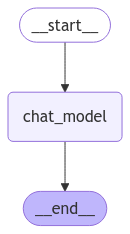

In [12]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
output = graph.invoke({'messages': messages})
print(output)
print(output['messages'])

{'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='fd0b59ae-2191-4328-af06-5aa16e70b4fc'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='a8b6651f-6cec-42a2-9af2-4a8595e69cc8'), AIMessage(content="That's great you're interested in ocean mammals! Whales are a fascinating group, but there's a whole underwater world beyond them.  Here are some other ocean mammal groups you should learn about:\n\n**1. Seals, Sea Lions, and Walruses (Pinnipeds):**\n\n* **Seals:** These are generally characterized by their lack of external ear flaps (pinnae), shorter flippers, and a more streamlined body for underwater movement.  There are several types, including harbor seals, elephant seals, leopard seals, etc., each with unique adaptations and behaviors.\n* **Sea Lions:**  Distinguished by their external ear flaps

In [16]:
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're familiar with whales!  There's a whole underwater world of fascinating mammals beyond them. To suggest further research, let's break it down by group:

**1.  Carnivora (Meat-Eaters):**

* **Seals:**  This is a large group with diverse species.  Learn about the differences between:
    * **Harp seals:** Known for their white coats as pups.
    * **Elephant seals:**  Massive size and distinctive proboscis.
    * **Harbor seals:** Common and often found near coasts.
    * **Leopard seals:**  Powerful predators.
    * **Weddell seals:**  Masters of surviving in Antarctic ice.
* **Sea Lions:**  Dis

In [18]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

      # on_chain_start = start of node's execution
      # on_chain_end = indicates completion of node's execution
      # on_chain_stream = Represent intermediate data or progress updates during a node's execution

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='fd0b59ae-2191-4328-af06-5aa16e70b4fc'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='a8b6651f-6cec-42a2-9af2-4a8595e69cc8')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'd9546fc3-b3ea-4997-9457-6d031697d567', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='fd0b59ae-2191-4328-af06-5aa16e70b4fc'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='a8b6651f-6cec-42a2-9af2-4a8595e69cc8')]}}, 'name': '__start__', '

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

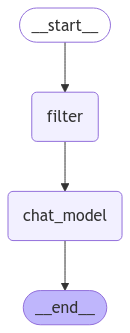

In [19]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState) -> MessagesState:
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a fantastic starting point, but there's a whole world beyond them.  To suggest further research, I need a little more direction. What aspects of ocean mammals interest you most?  For example, are you interested in:

* **Specific habitats?** (e.g., Arctic mammals, deep-sea mammals, coastal mammals)  This will greatly influence which animals you'll find.
* **Specific behaviors?** (e.g., migration patterns, social structures, hunting techniques)  Focusing on a behavior will lead you to animals known for that behavior.
* **Specific evolutionary aspects?** (e

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

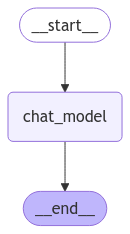

In [21]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [22]:
print(output['messages'][-1])

content="That's great you're interested in ocean mammals! Whales are a fantastic starting point, but there's a whole world beyond them.  To suggest further research, I need a little more direction. What aspects of ocean mammals interest you most?  For example, are you interested in:\n\n* **Specific habitats?** (e.g., Arctic mammals, deep-sea mammals, coastal mammals)  This will greatly influence which animals you'll find.\n* **Specific behaviors?** (e.g., migration patterns, social structures, hunting techniques)  Focusing on a behavior will lead you to animals known for that behavior.\n* **Specific evolutionary aspects?** (e.g., adaptations to different environments, evolutionary relationships between species)  This would guide you towards phylogenetic studies and comparative anatomy.\n* **Conservation status?** (e.g., endangered species, threats to their populations)  This will focus your research on species facing significant challenges.\n\nOnce I know what aspects interest you, I c

In [23]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [24]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a fantastic starting point, but there's a whole world beyond them.  To suggest further research, I need a little more direction. What aspects of ocean mammals interest you most?  For example, are you interested in:

* **Specific habitats?** (e.g., Arctic mammals, deep-sea mammals, coastal mammals)  This will greatly influence which animals you'll find.
* **Specifi

In [25]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a fantastic starting point, but there's a whole world beyond them.  To suggest further research, I need a little more direction. What aspects of ocean mammals interest you most?  For example, are you interested in:

* **Specific habitats?** (e.g., Arctic mammals, deep-sea mammals, coastal mammals)  This will greatly influence which animals you'll find.
* **Specifi

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

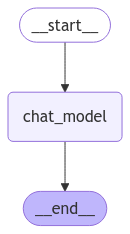

In [35]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last", #Retain the last messages upto the token limit
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key = google_api_key),
            allow_partial=False, #Prevent partial from being included
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
print(output['messages'][-1])

content='Narwhals ( *Monodon monoceros*) are truly unique and fascinating creatures.  Here\'s a breakdown of what makes them special:\n\n**The Defining Feature: The Tusk**\n\n* **Only males typically have a tusk:** This spiraled "tusk" is actually an elongated left incisor tooth that can grow up to 8-10 feet long.  Females rarely develop a tusk, and if they do, it\'s much smaller and remains embedded in the upper jaw.\n* **Sensory organ:**  Scientists believe the tusk is highly sensitive, containing millions of nerve endings.  It\'s theorized to be used for sensing changes in water pressure, temperature, and salinity, helping the narwhal navigate and find prey in the murky Arctic waters. It may also play a role in social interactions, such as fighting or courtship displays.\n* **Not just for show:** While the tusk\'s role in sensing is increasingly accepted, the idea that it\'s solely for show or fighting is now less emphasized.  The combination of sensory and social functions is likel

In [37]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [38]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key = google_api_key ),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [39]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r